In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
device = torch.device("cpu")

### Defining netwroks with two linear layers. The network reads 3 parameters D_in, H, D_out, where H is the hidden dimension. The linear network works as two matrix multiplication. The first linear layer clamps output at 0 as RELU. The second linear layer output logits.

In [3]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, D_in, H, D_out):    
        super(TwoLayerNet, self).__init__()
        
        self.linear1=nn.Linear(D_in, H)
        self.linear2=nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        
        return y_pred

### Predefined parameters

In [4]:
# N=number of sample, D_in=Input dimensions, H=Hidden dimension, D_out=Number of classes
N, D_in, H, D_out = 55, 200, 100, 11
train_mus = range(D_out) # means centered each classification
train_sigma = 0.2 # standard deviation

# test mus step by 0.01 and start 0.5 below the lowest train_mu and end 0.5 above the
# largest train_mu
test_mus = np.arange(min(train_mus)-0.5,max(train_mus)+0.5,0.01)
test_sigma = train_sigma

# this s_factor will be used to scale all values down in the testing and training
# data so that calculations in the model are cleaner. This has shown to improve output
s_factor = 2*max(train_mus)
scale = lambda x: x/s_factor

scaled_train_mus = list(map(scale, train_mus)) 
scaled_train_sigma = scale(train_sigma)
scaled_test_sigma = scale(test_sigma)
scaled_test_mus = list(map(scale,test_mus))


label_vals = torch.tensor([[list(range(D_out)) for i in range(N)]])

visualize = False

## Predefined data
Each sample is a collection of points centered around a Gaussian distribution. Each sample's points are sorted. The training of the model is performed on scaled down versions of the input for better accuracy in calculations. 

In [5]:
# Input data
X_train = torch.tensor([np.sort(np.random.normal(train_mus[i%D_out], \
                                                    train_sigma, D_in)) for i in range(N)], dtype=torch.float32)
    
y = torch.zeros(N, dtype=torch.long)
# classified to 0,1,2,3,4,5,6,8,9,10 based on where mean was located initially
for i,x in enumerate(X_train):
    y[i] = round(float(torch.mean(x))) 
    
X_test = torch.tensor([np.sort(np.random.normal(test_mus[i], \
    test_sigma, D_in)) for i in range(len(test_mus))], dtype=torch.float32)


X_left_half = X_test[:int(X_test.shape[0]/2)]
X_right_half = X_test[int(X_test.shape[0]/2):]
# X_one_ten will be the data with means closest to 1 and 10
X_one_ten = torch.cat((X_test[:int(X_test.shape[0]/11)],X_test[int(X_test.shape[0]*10/11):]))

scaled_X_train = scale(X_train)
scaled_X_test = scale(X_test)
scaled_X_left_half = scale(X_left_half)
scaled_X_right_half = scale(X_right_half)
scaled_X_one_ten = scale(X_one_ten)

### Predefined Data Visualization

In [6]:
if visualize == True:
    sns.distplot(X_train[0])
    plt.title('Feature Distribution of Single Sample from Training Data')
    plt.xlabel('Sample Feature Value')
    plt.ylabel('Frequency')

In [7]:
if visualize == True:
    print('X_train shape is:',X_train.shape)

    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}

    # plots each sample in the training set
    for i, data in enumerate(X_train):
        sns.distplot(data, hist = False, color= colors[i%len(train_mus)]) 

    plt.title('Training Data')
    plt.show()
    print(colors)

    print('y shape is:',y.shape)
    print('y:',y)


    print('\nX_test shape is:',X_test.shape)
    # plots each sample in the testing set
    for x in X_test:
        sns.distplot(x, hist = False)
    # plt.boxplot(X.tolist())
    plt.title('Test Data')
    plt.show()

#### Classification Visualization

In [8]:
if visualize == True:
    x_samples = []
    # stores the mean, standard deviation, and classification of a sample that will be put in
    # a dataframe for easier visualization
    for i,x in enumerate(X_train):
        x_i = [float(torch.mean(x)),float(torch.std(x)),y[i]]
        x_samples.append(x_i)

    x_samples = np.array(x_samples)

    # Dataframes of samples whose columsn are mean, standard deviation, and classification
    df = pd.DataFrame(dict(Mean=x_samples[:,0], Standard_Deviation=x_samples[:,1], label=x_samples[:,2]))

    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')

    # Plots the classifications of each sample along with its mean and standard deviation.
    # The classifications should correspond to sample mean and not sample standard deviation
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
    plt.xticks(np.arange(min(train_mus),max(train_mus)+1,1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Training Data Classifications')
    plt.show()

In [9]:
print(X_train.shape)
print(y.shape)
print(X_test.shape)

torch.Size([55, 200])
torch.Size([55])
torch.Size([1100, 200])


### Predefined functions

In [10]:
softmax=torch.nn.Softmax(dim=-1)
loss_fn = nn.CrossEntropyLoss()

## Building model

### Initial Training
This function will train the model unconstrained and return the model

In [11]:
def initial_model(scaled_X_train, lr, num_ops):
    model = TwoLayerNet(D_in, H, D_out)
    # Learning rate
    lr=lr# 5e-3
    # Number of optimization
    num_ops = num_ops #80000 

    # performs gradient descent
    for i in range(num_ops):
        Y=model(scaled_X_train)
        Y_softmax = torch.softmax(Y, dim = 1)
        cross_entropy = loss_fn(Y,y)
        loss = cross_entropy

        model.zero_grad()

        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

        if i%10000 == 0:
            print('i=',i,'loss.data=',loss.data)
            
    return model

### Homogenous Labeling
This function will take in the initial unconstrained model and the testing data and calculate the label that 

In [12]:
def homo_predict(scaled_X_train, scaled_X_test, X_test, initial_model):
    
    ## *VISUALIZATION OF UNCONSTRAINED CLASSIFICATION PLOT* ##
    Y_test = torch.argmax(softmax(initial_model(scaled_X_test)), axis=1)
    
    samples = []
    # prepares test data for being put into a dataframe
    for i,x in enumerate(X_test):
        x_i = [float(torch.mean(x)),float(torch.std(x)),Y_test[i]]
        samples.append(x_i)

    samples = np.array(samples)

    # test data DataFrame where the 1st column is mean, 2nd is std, and third is classification
    df = pd.DataFrame(dict(Mean=samples[:,0], Standard_Deviation=samples[:,1], label=samples[:,2]))
    
    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')

    # Plots all of the test data samples based on mean and standard deviation and color codes
    # its classification
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
    plt.xticks(np.arange(min(test_mus)+0.5,max(test_mus),1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Testing Data Unconstrained Classifications')
    plt.grid(axis='x')
    plt.show()
    
    
    ## *CALCULATION AND GRAPHING OF COST TO ENFORCE HOMOGENOUS LABEL FOR EACH LABEL* ##
    Y_test = initial_model(scaled_X_test).detach()
    Y_N = Y_test.shape[0]
    losses = []
    for c in range(D_out):
        homo_y = torch.tensor([c]*Y_N) # [0,0,...0] for example
        losses.append(loss_fn(Y_test,homo_y).detach())

    plt.bar(range(len(losses)),losses,color='lightblue')
    plt.title('Homogenous Label Enforcement Cross Entropy Loss')
    plt.ylabel('Cost')
    plt.xlabel('Label')
    plt.show()
    
    optim_label = np.argmin(losses)
    # tensor with inverse weights of target distribution. This means those labels with lower
    # values in inv_dist will be upweighted
    unimodal = np.ones(D_out)
    unimodal[optim_label] = 0
    inv_dist = torch.tensor([unimodal for i in range(N)])
    
    
    ## *RETRAINING TO ENFORCE HOMOGENOUS LABEL CONSTRAINT* ##
    index = []
    losses = {'mu_dist':[],'cross_entropy':[],'total':[]}

    model = TwoLayerNet(D_in, H, D_out)
    lr =1e-3
    num_ops = 100000
    # Penalty term
    mu_dist = 80

    # performs gradient descent
    for i in range(num_ops):
        Y=model(scaled_X_train)
        Y_softmax = torch.softmax(Y, dim = 1)
        dist_penalty = 0.5*mu_dist*torch.mean(Y_softmax*inv_dist)
        cross_entropy = loss_fn(Y,y)
        loss = cross_entropy + dist_penalty

        # stores these values for graphing later
        index.append(i)
        losses['cross_entropy'].append(cross_entropy)
        losses['mu_dist'].append(dist_penalty)
        losses['total'].append(loss)

        model.zero_grad()

        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

        if i%20000 == 0:
            print('i=',i,'loss.data=',loss.data,'distribution penalty=',dist_penalty)
            
            
    ## *VISUALIZATION OF LOSS DURING RETRAINING* ##
    plt.plot(index,losses['cross_entropy'], label = 'Cross Entropy')
    plt.plot(index,losses['mu_dist'], label = 'Distribution Penalty Term')
    plt.plot(index,losses['total'], label = 'Complete Loss Function')
    plt.title('Loss Function Analysis')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
    print('inv_dist[0] = ',inv_dist[0])
            
    Y_test = torch.argmax(softmax(model(scaled_X_test)), axis=1)

    ## *VISUALIZATION OF DISTRIBUTION OF LABELS* ##
    bins = range(torch.max(y) + 2)
    plt.hist(Y_test, bins=bins)
    plt.xticks(bins)
    plt.xlabel('Classification')
    plt.ylabel('Frequency')
    plt.title('Constrained Classification Distribution')
    plt.show()

    print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
    print('inv_dist[0] = ',inv_dist[0])
    
    
    ## *VISUALIZATION OF CLASSIFICATION BASED ON MEAN & STANDARD DEVIATION* ##
    samples = []
    # prepares test data for being put into a dataframe
    for i,x in enumerate(X_test):
        x_i = [float(torch.mean(x)),float(torch.std(x)),Y_test[i]]
        samples.append(x_i)

    samples = np.array(samples)

    # test data DataFrame where the 1st column is mean, 2nd is std, and third is classification
    df = pd.DataFrame(dict(Mean=samples[:,0], Standard_Deviation=samples[:,1], label=samples[:,2]))
    
    colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
    fig, ax = plt.subplots()
    grouped = df.groupby('label')

    # Plots all of the test data samples based on mean and standard deviation and color codes
    # its classification
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
    plt.xticks(np.arange(min(test_mus)+0.5,max(test_mus),1))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Testing Data Constrained Classifications')
    plt.grid(axis='x')
    plt.show()

    print('learning rate =',lr,'; iterations =',num_ops,'; mu_dist =',mu_dist)
    print('inv_dist[0] = ',inv_dist[0])



# Output

### Initial Output
The first cell shows the results of initial unconstrained training

i= 0 loss.data= tensor(2.4139)
i= 10000 loss.data= tensor(1.1089)
i= 20000 loss.data= tensor(0.6702)
i= 30000 loss.data= tensor(0.4627)
i= 40000 loss.data= tensor(0.3358)
i= 50000 loss.data= tensor(0.2497)
i= 60000 loss.data= tensor(0.1889)
i= 70000 loss.data= tensor(0.1455)


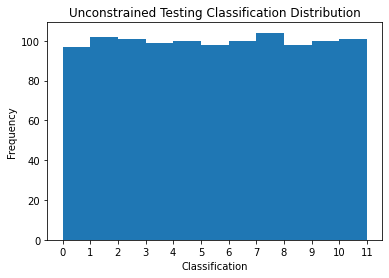

learning rate = 0.005 ; iterations = 79500


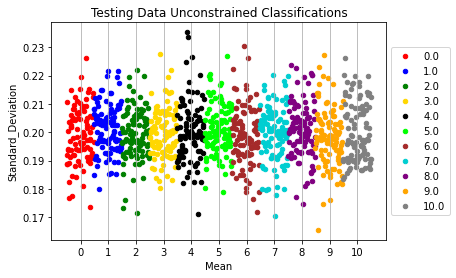

learning rate = 0.005 ; iterations = 79500


In [13]:
lr=5e-3
num_ops=79500

initial_model = initial_model(scaled_X_train,lr=lr,num_ops=num_ops)

Y_test = torch.argmax(softmax(initial_model(scaled_X_test)), axis=1)

bins = range(torch.max(y) + 2)
plt.hist(Y_test, bins=bins)
plt.xticks(bins)
plt.xlabel('Classification')
plt.ylabel('Frequency')
plt.title('Unconstrained Testing Classification Distribution')
plt.show()

print('learning rate =',lr,'; iterations =',num_ops)

samples = []
# prepares test data for being put into a dataframe
for i,x in enumerate(X_test):
    x_i = [float(torch.mean(x)),float(torch.std(x)),Y_test[i]]
    samples.append(x_i)

samples = np.array(samples)

# test data DataFrame where the 1st column is mean, 2nd is std, and third is classification
df = pd.DataFrame(dict(Mean=samples[:,0], Standard_Deviation=samples[:,1], label=samples[:,2]))

colors = {0:'red', 1:'blue', 2:'green',3:'gold',4:'black',5:'lime',6:'brown',\
              7:'darkturquoise',8:'purple',9:'orange',10:'gray'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

# Plots all of the test data samples based on mean and standard deviation and color codes
# its classification
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='Mean', y='Standard_Deviation', label=key, color=colors[key])
plt.xticks(np.arange(min(test_mus)+0.5,max(test_mus),1))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Testing Data Unconstrained Classifications')
plt.grid(axis='x')
plt.show()

print('learning rate =',lr,'; iterations =',num_ops)


### Homogenous Labeling Enforcement
This code performs the homogenous label enforcement and visualizes the results along the way

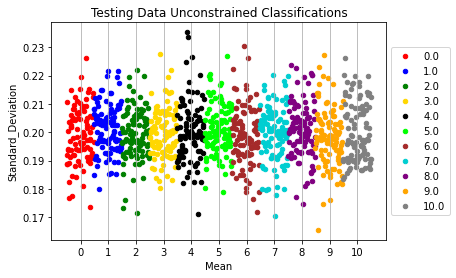

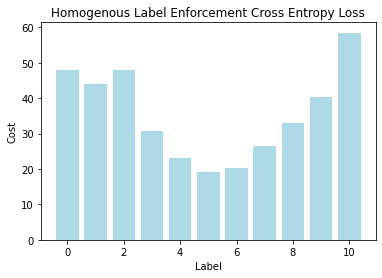

i= 0 loss.data= tensor(5.7219, dtype=torch.float64) distribution penalty= tensor(3.2912, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 20000 loss.data= tensor(3.5720, dtype=torch.float64) distribution penalty= tensor(0.9089, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 40000 loss.data= tensor(3.3055, dtype=torch.float64) distribution penalty= tensor(0.9186, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 60000 loss.data= tensor(3.0727, dtype=torch.float64) distribution penalty= tensor(0.9017, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 80000 loss.data= tensor(2.9024, dtype=torch.float64) distribution penalty= tensor(0.9007, dtype=torch.float64, grad_fn=<MulBackward0>)


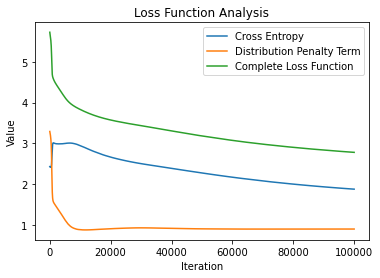

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=torch.float64)


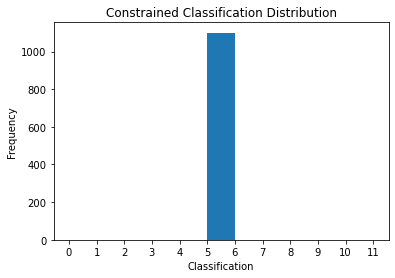

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=torch.float64)


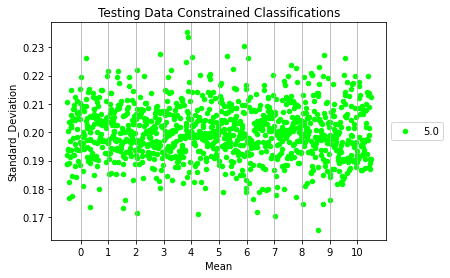

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=torch.float64)


In [15]:
homo_predict(scaled_X_train, scaled_X_test, X_test, initial_model)

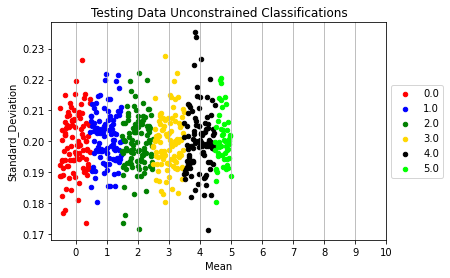

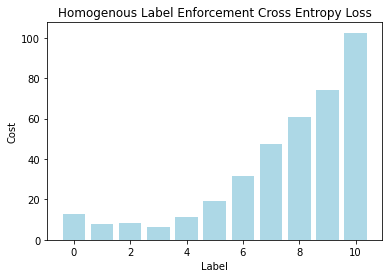

i= 0 loss.data= tensor(5.7512, dtype=torch.float64) distribution penalty= tensor(3.3351, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 20000 loss.data= tensor(3.5893, dtype=torch.float64) distribution penalty= tensor(0.9076, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 40000 loss.data= tensor(3.2978, dtype=torch.float64) distribution penalty= tensor(0.9052, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 60000 loss.data= tensor(3.0594, dtype=torch.float64) distribution penalty= tensor(0.8960, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 80000 loss.data= tensor(2.8944, dtype=torch.float64) distribution penalty= tensor(0.8989, dtype=torch.float64, grad_fn=<MulBackward0>)


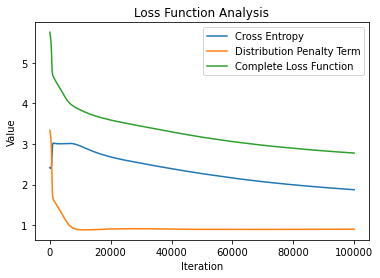

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


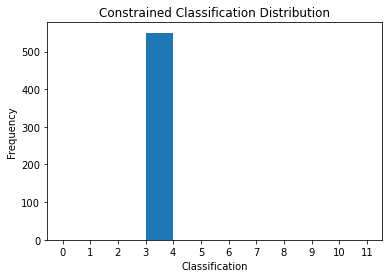

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


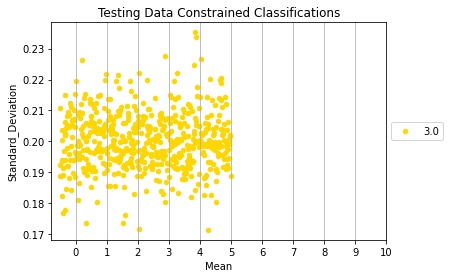

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)


In [16]:
homo_predict(scaled_X_train, scaled_X_left_half, X_left_half, initial_model)

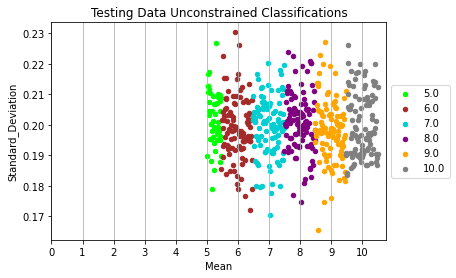

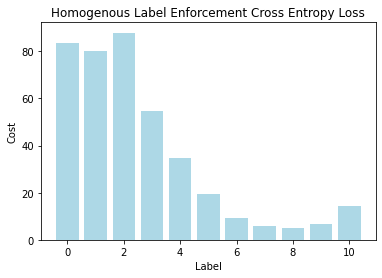

i= 0 loss.data= tensor(5.6640, dtype=torch.float64) distribution penalty= tensor(3.2683, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 20000 loss.data= tensor(3.6293, dtype=torch.float64) distribution penalty= tensor(0.9073, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 40000 loss.data= tensor(3.3118, dtype=torch.float64) distribution penalty= tensor(0.9010, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 60000 loss.data= tensor(3.0409, dtype=torch.float64) distribution penalty= tensor(0.8932, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 80000 loss.data= tensor(2.8641, dtype=torch.float64) distribution penalty= tensor(0.8977, dtype=torch.float64, grad_fn=<MulBackward0>)


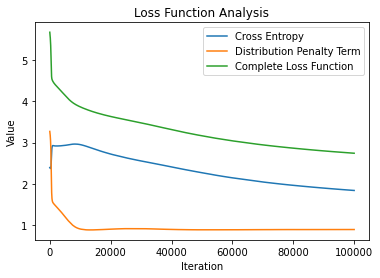

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.], dtype=torch.float64)


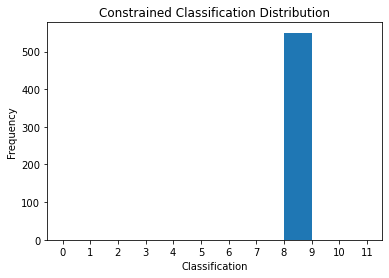

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.], dtype=torch.float64)


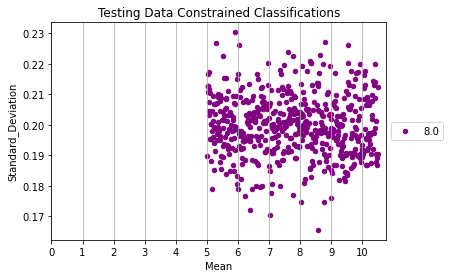

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.], dtype=torch.float64)


In [17]:
homo_predict(scaled_X_train, scaled_X_right_half, X_right_half, initial_model)

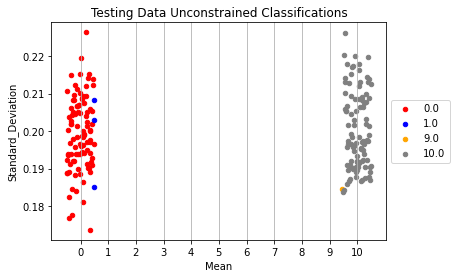

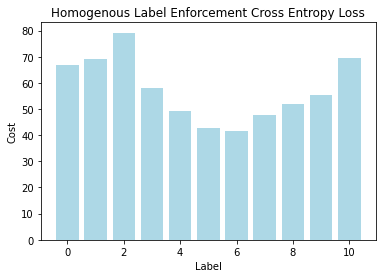

i= 0 loss.data= tensor(5.7507, dtype=torch.float64) distribution penalty= tensor(3.3360, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 20000 loss.data= tensor(3.5637, dtype=torch.float64) distribution penalty= tensor(0.9091, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 40000 loss.data= tensor(3.2633, dtype=torch.float64) distribution penalty= tensor(0.9117, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 60000 loss.data= tensor(3.0364, dtype=torch.float64) distribution penalty= tensor(0.9060, dtype=torch.float64, grad_fn=<MulBackward0>)
i= 80000 loss.data= tensor(2.8753, dtype=torch.float64) distribution penalty= tensor(0.9046, dtype=torch.float64, grad_fn=<MulBackward0>)


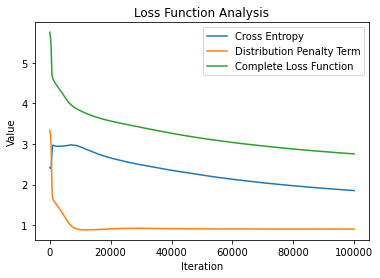

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=torch.float64)


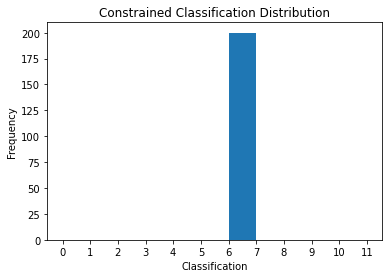

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=torch.float64)


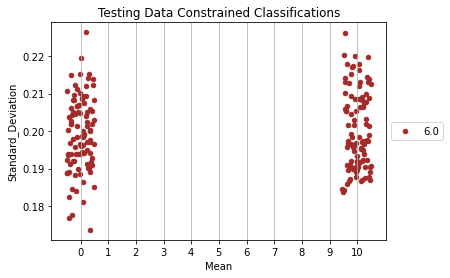

learning rate = 0.001 ; iterations = 100000 ; mu_dist = 80
inv_dist[0] =  tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.], dtype=torch.float64)


In [18]:
homo_predict(scaled_X_train, scaled_X_one_ten, X_one_ten, initial_model)